In [13]:
import pandas as pd
import matplotlib.pyplot as plt

REPLAY_START_SIZE = 50_000  # Size of replay memory before starting training

# Load the CSV files
df1 = pd.read_csv('../data/original_dqn_training_history.csv')
df2 = pd.read_csv('../data/rainbow_dqn_training_history.csv')
df_random = pd.read_csv('../data/random_training_history.csv')

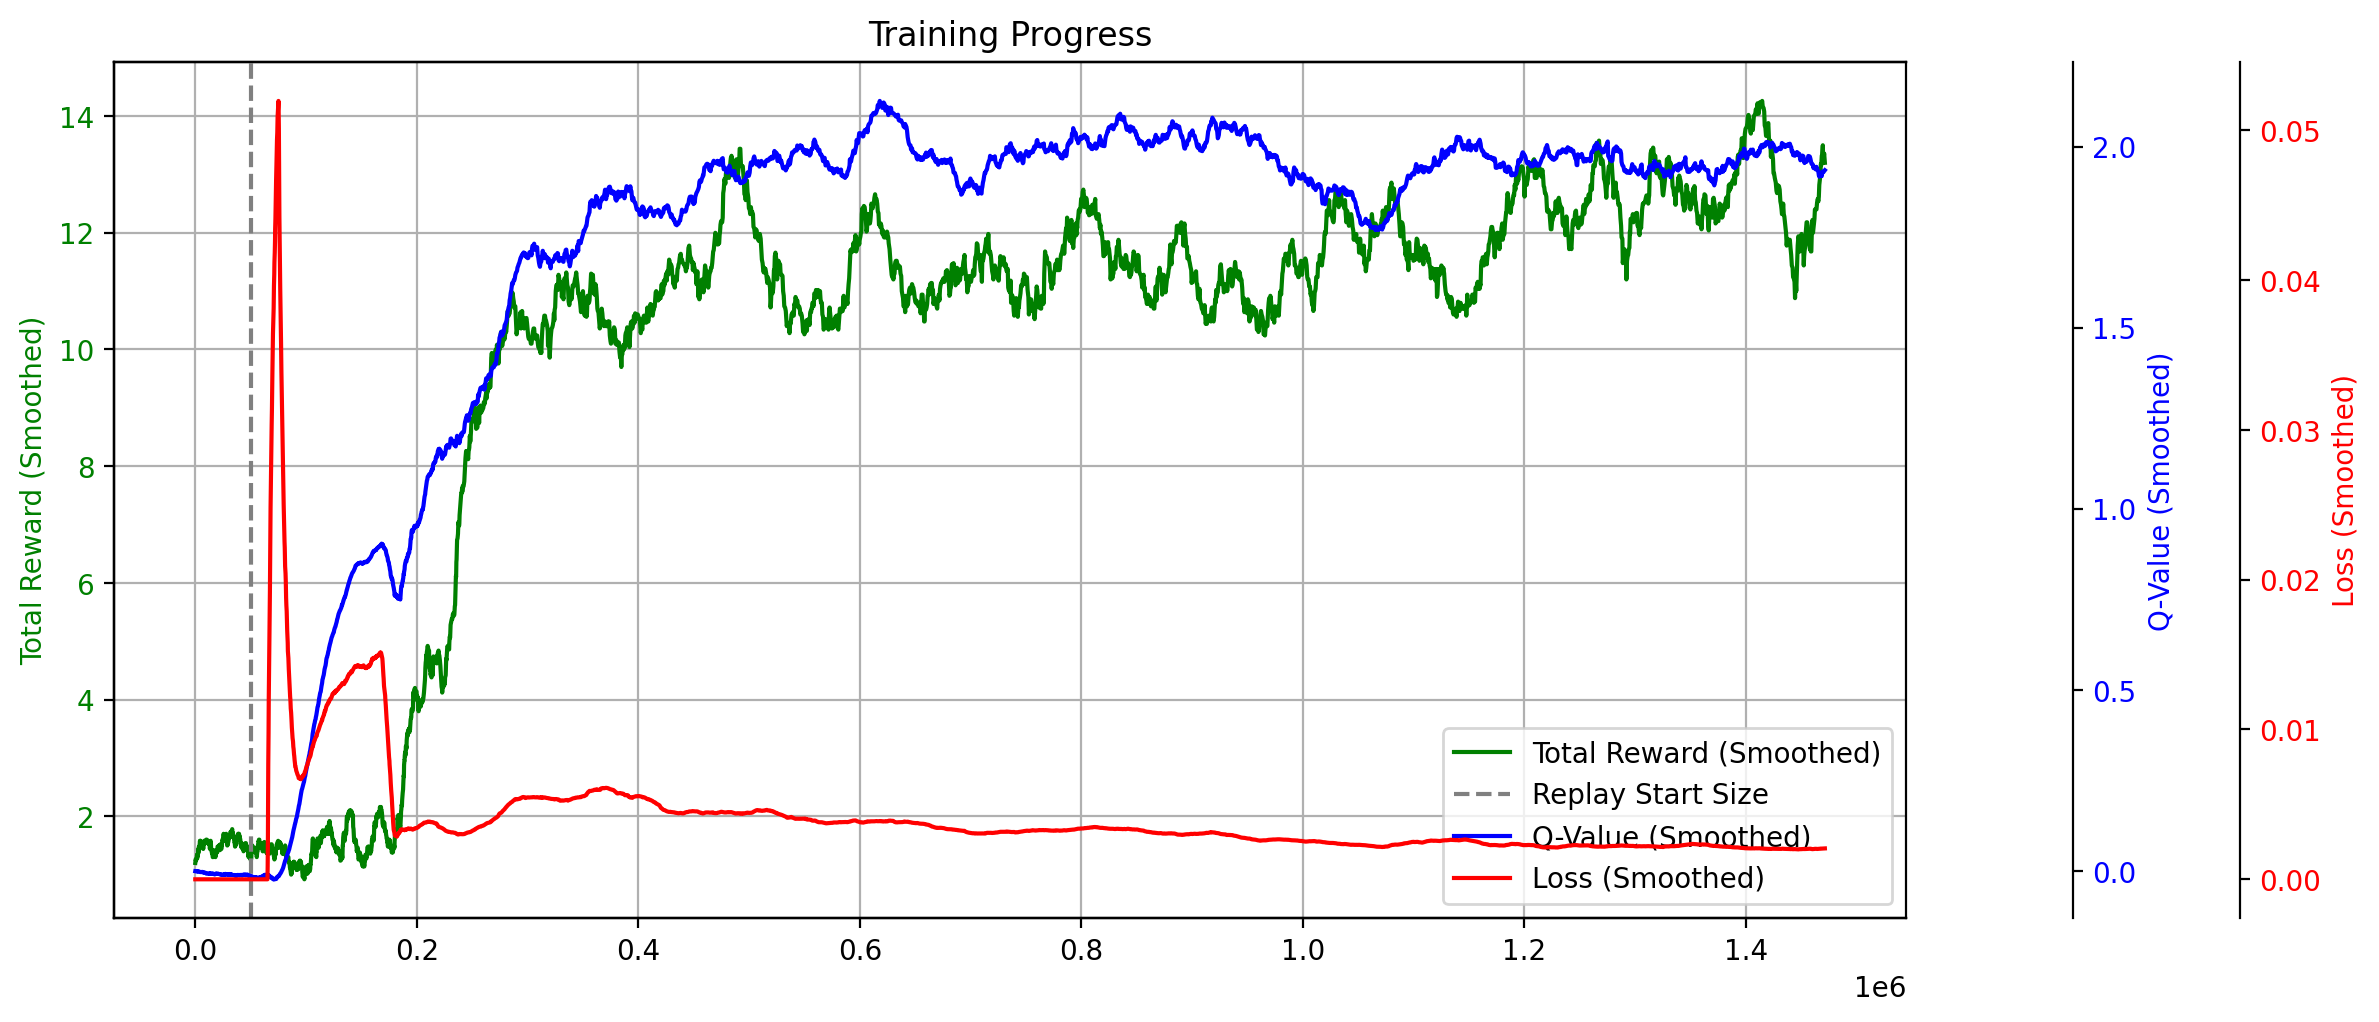

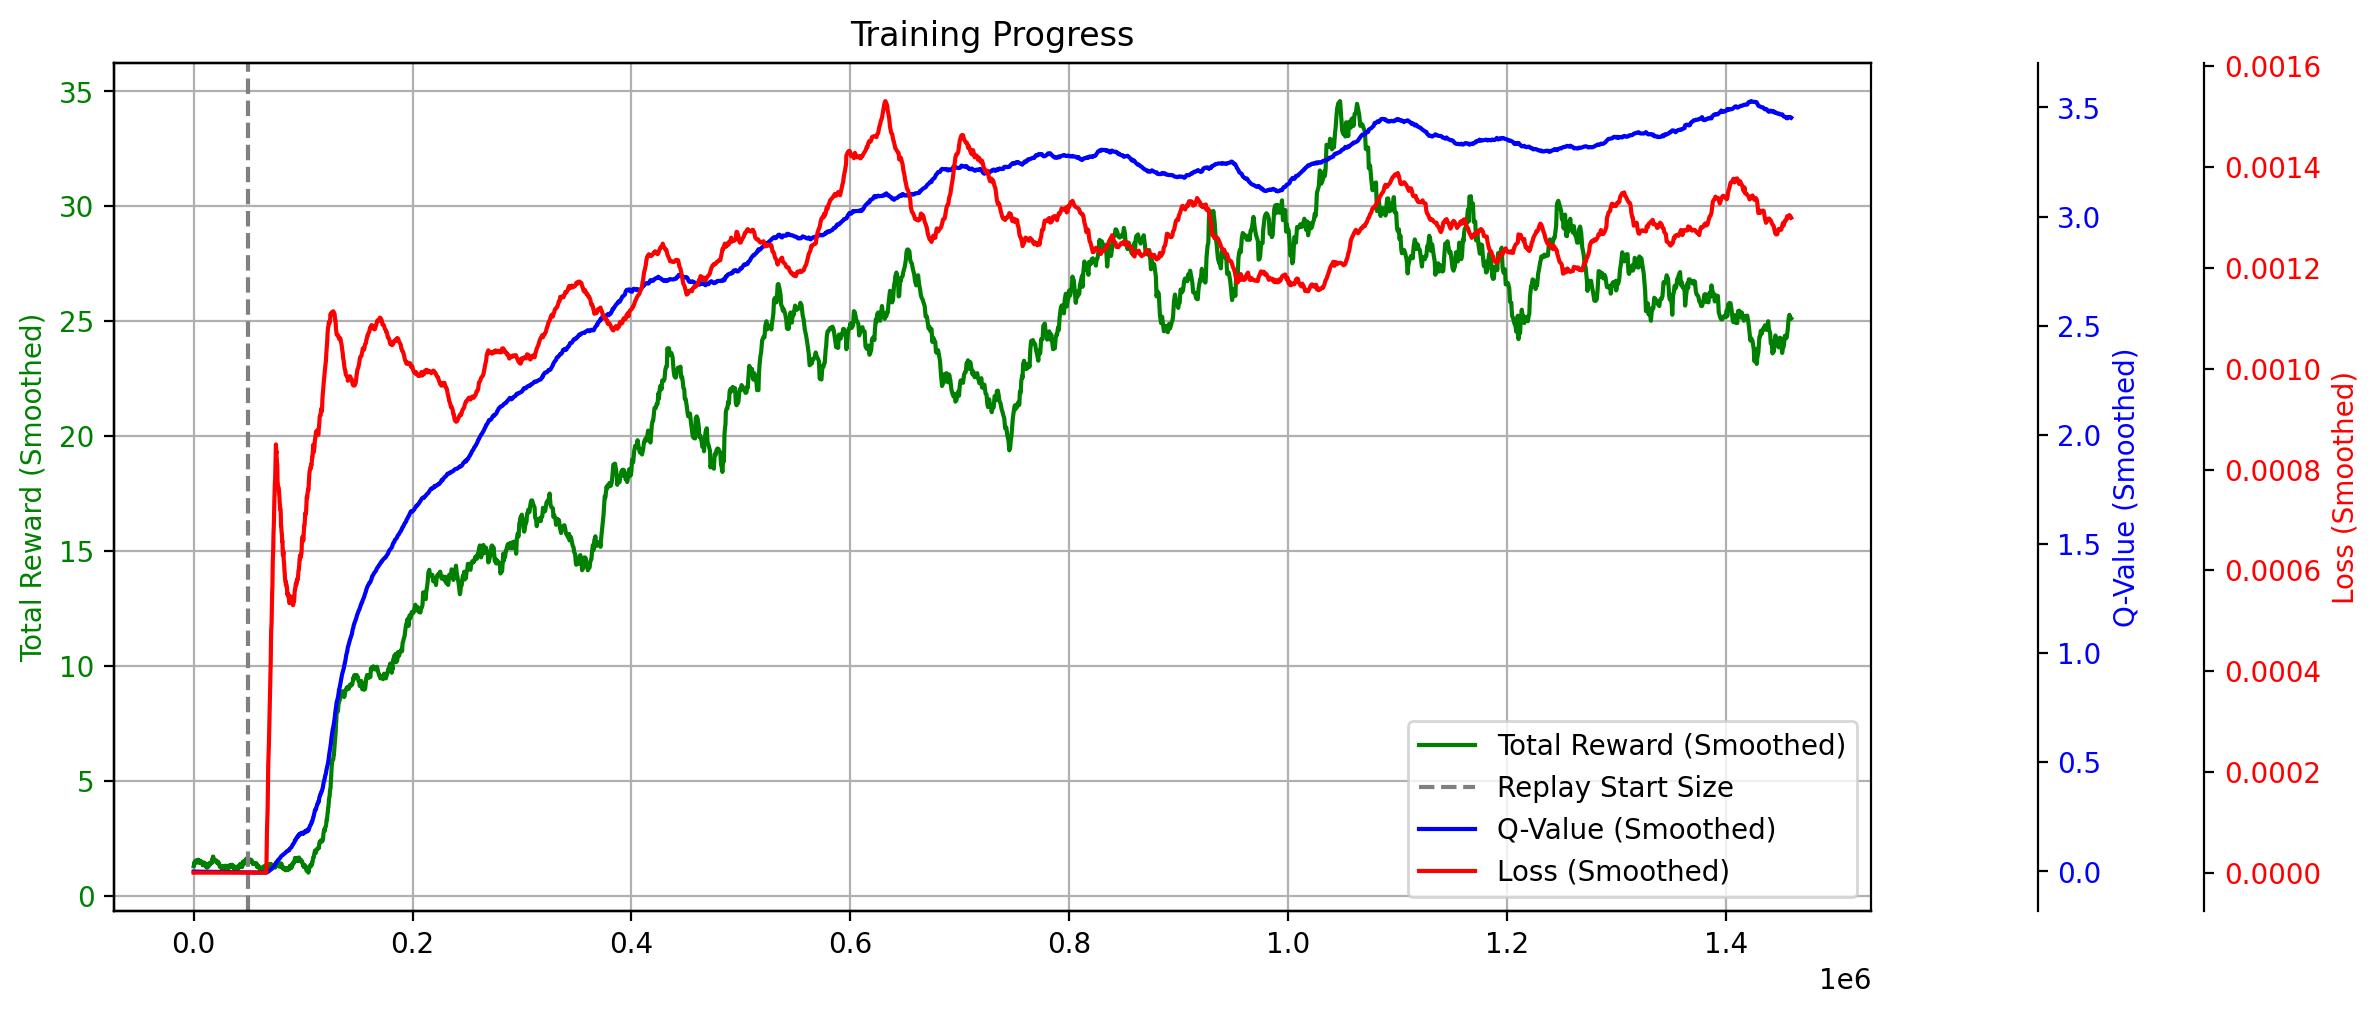

In [14]:
from utils.plot_dict import plot_dict

# Convert the DataFrame back to a dictionary
plot_infos_original = df1.to_dict(orient='list')

plot_dict(plot_infos_original, REPLAY_START_SIZE, dpi=200)

# Convert the DataFrame back to a dictionary
plot_infos_rainbow = df2.to_dict(orient='list')

plot_dict(plot_infos_rainbow, REPLAY_START_SIZE, dpi=200)

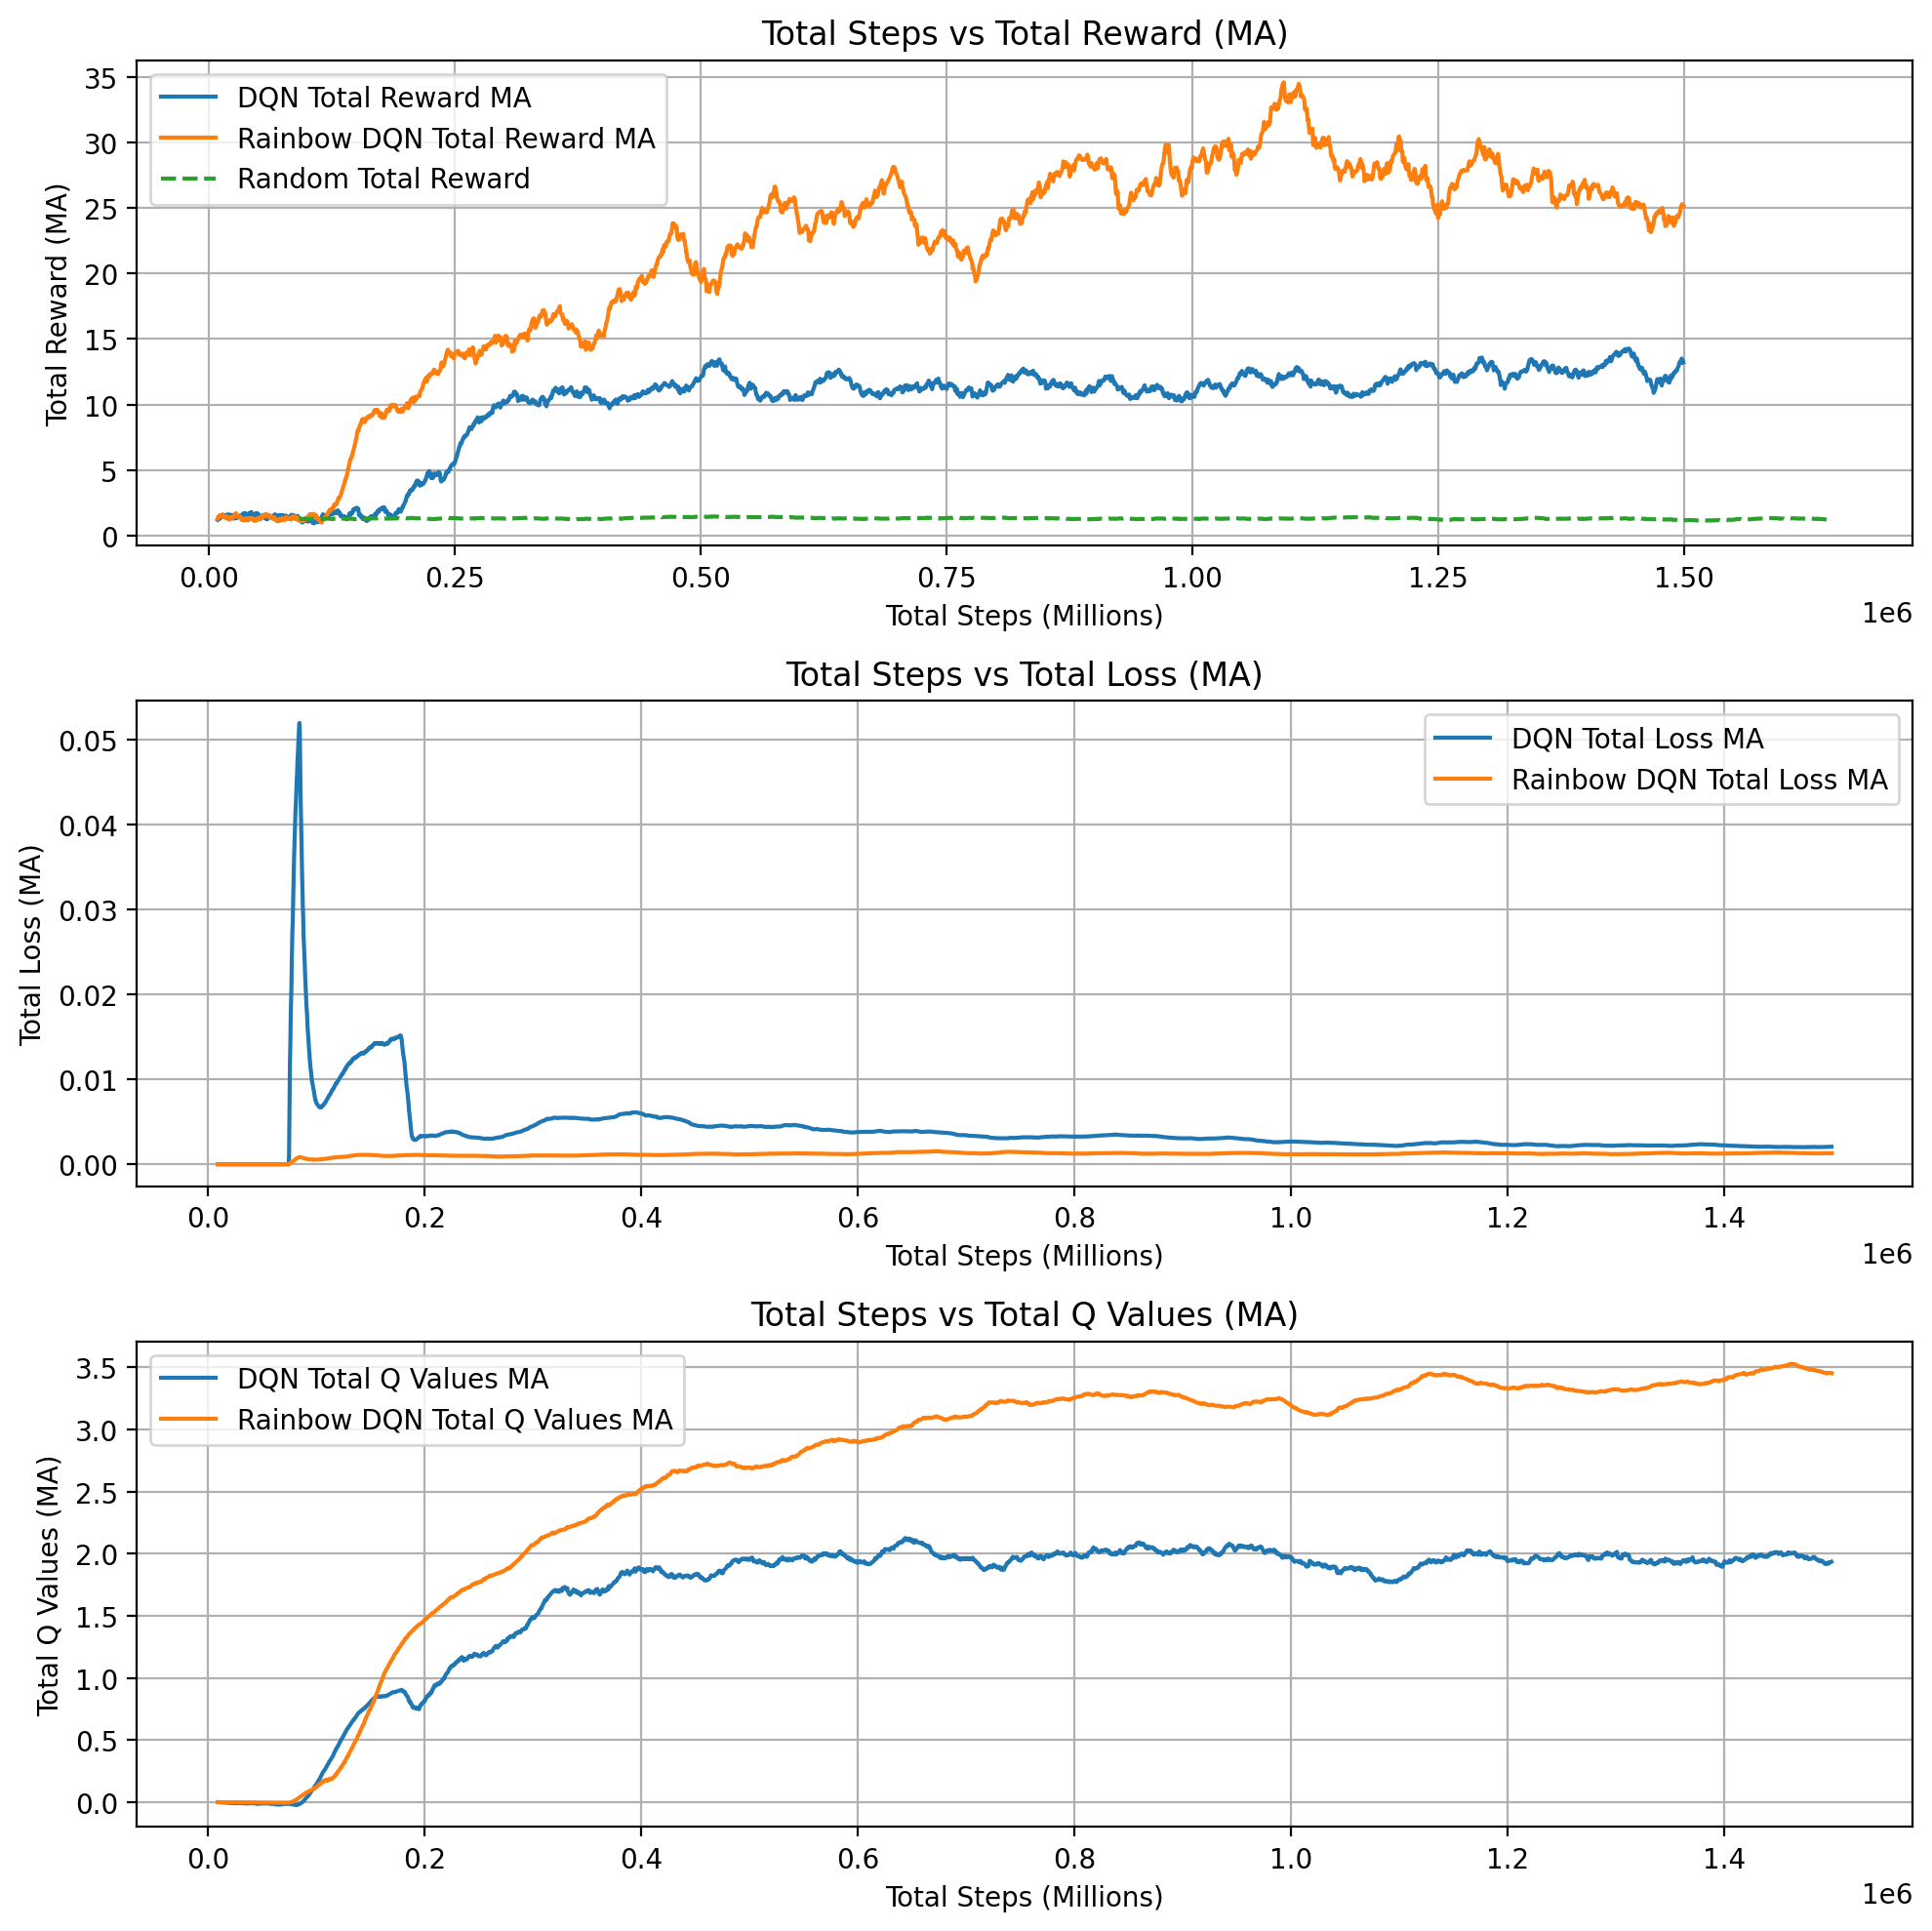

In [15]:

label1 = 'DQN'
label2 = 'Rainbow DQN'
label_random = 'Random'

# Calculate the moving average with a window of 500
df1['episode_rewards_ma'] = df1['episode_rewards'].rolling(window=50).mean()
df1['loss_ma'] = df1['loss'].rolling(window=50).mean()
df1['mean_q_value_ma'] = df1['mean_q_value'].rolling(window=50).mean()

df2['episode_rewards_ma'] = df2['episode_rewards'].rolling(window=50).mean()
df2['loss_ma'] = df2['loss'].rolling(window=50).mean()
df2['mean_q_value_ma'] = df2['mean_q_value'].rolling(window=50).mean()

df_random['episode_rewards_ma'] = df_random['episode_rewards'].rolling(window=500).mean()

# Plot the data
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 10), dpi=200)

# Plot steps vs episode_rewards moving average
axes[0].plot(df1['steps'], df1['episode_rewards_ma'], label=label1 + ' Total Reward MA')
axes[0].plot(df2['steps'], df2['episode_rewards_ma'], label=label2 + ' Total Reward MA')
axes[0].plot(df_random['steps'], df_random['episode_rewards_ma'], label=label_random + ' Total Reward', linestyle='--')
axes[0].set_title('Total Steps vs Total Reward (MA)')
axes[0].set_xlabel('Total Steps (Millions)')
axes[0].set_ylabel('Total Reward (MA)')
axes[0].legend()
axes[0].grid(True)

# Plot steps vs loss moving average
axes[1].plot(df1['steps'], df1['loss_ma'], label=label1 + ' Total Loss MA')
axes[1].plot(df2['steps'], df2['loss_ma'], label=label2 + ' Total Loss MA')
axes[1].set_title('Total Steps vs Total Loss (MA)')
axes[1].set_xlabel('Total Steps (Millions)')
axes[1].set_ylabel('Total Loss (MA)')
axes[1].legend()
axes[1].grid(True)

# Plot steps vs total_q_values moving average
axes[2].plot(df1['steps'], df1['mean_q_value_ma'], label=label1 + ' Total Q Values MA')
axes[2].plot(df2['steps'], df2['mean_q_value_ma'], label=label2 + ' Total Q Values MA')
axes[2].set_title('Total Steps vs Total Q Values (MA)')
axes[2].set_xlabel('Total Steps (Millions)')
axes[2].set_ylabel('Total Q Values (MA)')
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()